In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data_collector import Omie

from ml import GaussianKernel
from potenciala import BucketMethod, FigureShape, SingleTimeSeries, VectorTimeSeries
from stochastic import (EulerMaruyama, ConstantDiffusionMultivariate, SpatialDifferenceDriftMultivariate, 
                        SpatialDiffusionUnivariate, SpatialDriftMultivariate)

In [3]:
# uncomment this to obtain most up-to-date day ahead market timeseries
#df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)
#df = Omie.include_old_file(df=df, filename="marginalpdbc_2002_2015.csv")

In [4]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")
df_raw["spain"] = df_raw["spain"].round(decimals=2)

In [5]:
# filter data before 2004 (missing dates in 2003) and beyond 2021
df = df_raw.query("year >= 2004 & year <= 2020")

### Univariate timeseries

In [ ]:
s_1 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Round, bin_size=1)
s_025 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)

In [ ]:
s_1.plot_ts()

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))
s_1.potential.loc[:120].plot(ax=ax0)
s_025.potential.loc[:120].plot(ax=ax1)
ax0.set_title("1 €/MW resolution")
ax1.set_title("0.25 €/MW resolution")
plt.show()

### Include all history or last n years

In [ ]:
# Compare potential across different years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compare potential across different years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period divided by minimum
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# plot mean drift and diffusion
_ = s_1.drift.mean["drift_1"].iloc[:120].plot()

In [ ]:
_ = s_1.diffusion.mean["diffusion_1"].iloc[:120].plot()

In [ ]:
a = s_1.drift.mean["drift_1"]
a = a.reindex(np.arange(0, a.index.max() + 20)).fillna(0)
b = s_1.diffusion.mean["diffusion_1"]
b = b.reindex(np.arange(0, b.index.max() + 20)).fillna(0)

x_df = s_1.df[(s_1.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[0]

In [ ]:
drift = SpatialDriftMultivariate(df=a.to_frame())
diffusion = SpatialDiffusionUnivariate(df=b.to_frame())

em_1 = EulerMaruyama(num_sim=1000, period=24*6, delta_t=1, nu=0, drift=drift, diffusion=diffusion)

In [ ]:
sim_df = em_1.simulate(x0=np.array([x_0]), random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[:,  :em_1.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
plt.show()

### Multivariate  timeseries $D_{1}^h(X_{d}^h)$ 

In [ ]:
s = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1, 
                     diff_matrix_xi_xj_computation=False)

In [ ]:
s.plot_hourly_boxplot()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.drift_hour_x.iloc[:, :100], ax=ax, cmap='flare', vmin=-50, vmax=50)
ax.set_title("Mean 24-hour drift")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.potential_hour_x.iloc[:, :100], ax=ax, cmap='flare', vmin=-400, vmax=100)
ax.set_title("Potential")
fig.show()

In [ ]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(0, 180)
    ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

In [ ]:
fig, axis = plt.subplots(4, 6, figsize=(40, 25))

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*6+j
        s.potential_hour_x.loc[h].plot(ax=ax)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=30)
        ax.set_xlim(0, 100)
        ax.set_ylim(-450, 50)
        ax.tick_params(axis='both', labelsize=20)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.text(0.5, 0.095, "spot price $X_{t}^{i}$ [€/MWh]", ha="center", va="center", fontdict={"size": 25})
fig.text(0.1, 0.5, "potential $[(€/MWh)^{2}/day]$", ha="center", va="center",
         fontdict={"size": 25}, rotation=90)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s.potential_hour_x.iloc[:, :100].stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("Spot price [€/Mwh]")
ax.set_zlabel("potential")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s.diffusion_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.sqrt_diff_matrix, dtype=bool), k=1)
sns.heatmap(s.sqrt_diff_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D_{1}^h(X_{d}^h)$ and diagonal $D^{2}$

In [ ]:
x_df = s.df[(s.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [ ]:
spatial_drift = SpatialDriftMultivariate(df=s.drift_hour_x)
diag_diff_matrix = pd.DataFrame(np.sqrt(np.diag(np.diag(s.diffusion_matrix))))
diag_diffusion = ConstantDiffusionMultivariate(df=diag_diff_matrix)

em_2 = EulerMaruyama(num_sim=1000, period=6, delta_t=1, nu=0, drift=spatial_drift, diffusion=diag_diffusion)

In [ ]:
sim_df = em_2.simulate(x0=x_0, random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_2.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 120)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^{h}(X_d^h)$ and diagonal $D_2$")
plt.show()

#### Simulation with $D_{1}^h(X_{d}^h)$ and non-diagonal constant $D^{2}$

In [ ]:
x_df = s.df[(s.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [ ]:
spatial_drift = SpatialDriftMultivariate(df=s.drift_hour_x)
cte_diffusion = ConstantDiffusionMultivariate(df=pd.DataFrame(s.sqrt_diff_matrix))

em_3 = EulerMaruyama(num_sim=1000, period=6, delta_t=1, nu=0, drift=spatial_drift, diffusion=cte_diffusion)

In [ ]:
sim_df = em_3.simulate(x0=x_0, random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_3.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 120)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^h(X_d^h)$ and non-diagonal $D_2$")
plt.show()

### Multivariate timeseries  - $D_{1}^{h}(X_{d}^h - X_{d-1}^h)$ 

In [ ]:
s_back_drift = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1, x_transformation="back_drift")

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.samples_hour_x.iloc[:, :200], ax=ax, cmap='flare')#, vmin=-40, vmax=40)
ax.set_title("Samples 24-hour drift")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.drift_hour_x, ax=ax, cmap='flare')#, vmin=-40, vmax=40)
ax.set_title("Mean 24-hour drift")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.potential_hour_x, ax=ax, cmap='flare')
ax.set_title("Potential")
fig.show()

In [ ]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s_back_drift.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(-80, 80)
    #ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

In [ ]:
fig, axis = plt.subplots(4, 6, figsize=(40, 25))

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*6+j
        s_back_drift.potential_hour_x.loc[h].plot(ax=ax)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=30)
        ax.set_xlim(-60, 60)
        ax.set_ylim(-800, 50)
        ax.tick_params(axis='both', labelsize=20)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.text(0.5, 0.095, "spot price difference $X_{t}^{i} - X_{t-1}^{i}$ [€/MWh]", ha="center", va="center", fontdict={"size": 25})
fig.text(0.1, 0.5, "potential $[(€/MWh)^{2}/day]$", ha="center", va="center",
         fontdict={"size": 25}, rotation=90)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s_back_drift.potential_hour_x.stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("X")
ax.set_zlabel("potential")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s_back_drift.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s_back_drift.diffusion_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D_{1}^h(X_{d}^h - X_{d-1}^h)$ and non-diagonal constant $D^{2}$

In [ ]:
x_df = s_back_drift.df[(s_back_drift.df["date"] >= "2020-12-09")].iloc[:24*7]
t_0 = x_df["spain"].iloc[:24].values
t_1 = x_df["spain"].iloc[24:48].values
x_0 = np.vstack([t_0, t_1]).T

In [ ]:
spatial_diff_drift = SpatialDifferenceDriftMultivariate(df=s_back_drift.drift_hour_x)
cte_diffusion = ConstantDiffusionMultivariate(df=pd.DataFrame(s_back_drift.sqrt_diff_matrix))

em_4 = EulerMaruyama(num_sim=1000, period=7, delta_t=1, nu=0, drift=spatial_diff_drift, diffusion=cte_diffusion)

In [ ]:
sim_df = em_4.simulate(x0=x_0, random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[48:, : em_4.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).iloc[24:].plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].iloc[24:].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[48:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 120)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation for $D_1^h(X_d^h - X_{d-1}^h)$ and non-diagonal $D_2$")
plt.show()

## Gaussian kde

In [6]:
from scipy import integrate, stats
from matplotlib.lines import Line2D

In [7]:
s_kde = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.NoBucket)

In [8]:
def fit_gaussian_kde(df: pd.DataFrame):
    
    values = df.values.T
    kernel = stats.gaussian_kde(values)
    return kernel, values

def generate_mesh(values: np.ndarray, 
                  x_num: int, y_num: int, z_num: int = None, 
                  xmin: float = None, xmax: float = None,
                  ymin: float = None, ymax: float = None,
                  zmin: float = None, zmax: float = None):
    
    xmin = values[0].min().round(2) if not xmin else xmin
    xmax = values[0].max().round(2) if not xmax else xmax
    #xmax = xmax if xmax >= 100 else 100
    
    ymin = values[1].min().round(2) if not ymin else ymin
    ymax = values[1].max().round(2) if not ymax else ymax
    
    x_mesh = np.linspace(xmin, xmax, x_num)
    y_mesh = np.linspace(ymin, ymax, y_num)
    

    if values.shape[0] == 3:
        zmin = values[2].min().round(2) if not zmin else zmin
        zmax = values[2].max().round(2) if not zmax else zmax

        z_mesh = np.linspace(zmin, zmax, z_num)

        X, Y, Z = np.meshgrid(*(x_mesh, y_mesh, z_mesh), indexing="ij")
        mesh = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
        
        return mesh, X, Y, Z
    
    else:
        X, Y = np.meshgrid(*(x_mesh, y_mesh), indexing="ij")
        mesh = np.vstack([X.ravel(), Y.ravel()])
        
        return mesh, X, Y

def compute_mesh_probability(kernel: stats.kde.gaussian_kde, mesh: np.ndarray, new_shape: tuple):
    
    p = np.reshape(kernel(mesh).T, new_shape)
    return p

def compute_expected_value(x_grid: np.ndarray, y_grid: np.ndarray, p: np.ndarray):
    
    x_range = x_grid[:, 0]
    expected_value_x = np.zeros_like(x_range)
    for i in range(x_range.shape[0]):
        # this computes the expected value even if the probability (weights) are not normalised 
        # https://numpy.org/doc/stable/reference/generated/numpy.average.html
        expected_value_x[i] = np.average(y_grid[i], weights=p[i])
        
    return pd.Series(expected_value_x, index=x_range)

def compute_historical_mean(df: pd.DataFrame, x_label_col_name: str, value_col_name: str):
    
    aux_df = df.copy(deep=True)
    aux_df[x_label_col_name] = aux_df[x_label_col_name].round(decimals=0)
    mean_x = aux_df.groupby(x_label_col_name)[value_col_name].mean()
    
    return mean_x

def plot_samples_kernel_mean_expected(ax: plt.axes, h_stats: dict, ymax_lim: float = None):

    ax.plot(h_stats["values"][0], h_stats["values"][1], 'k.', markersize=2, alpha=0.2)
    h_stats["expected_value_x"].plot(ax=ax, lw=2, color="blue")
    h_stats["historical_mean_x"].plot(ax=ax, lw=2, color="red")
    cs = ax.contourf(h_stats["x_grid"], h_stats["y_grid"], h_stats["p"],
                     levels=100, cmap=plt.cm.gist_earth_r, alpha=0.7, antialiased=True)
    if ymax_lim:
        ax.set_ylim(0, ymax_lim)

$$D_1^{h}$$

In [9]:
def plot_potential(ax: plt.axis, h_stats: dict):
    
    ax.plot(h_stats["expected_value_x"].index, (-1)*np.cumsum(h_stats["expected_value_x"].values), color="blue")
    ax.plot(h_stats["historical_mean_x"].index, (-1)*np.cumsum(h_stats["historical_mean_x"].values), color="red")

In [ ]:
d_1_hour_stats = {}
for h in s_kde.df["hour"].unique():
    train_df = s_kde.df.query(f"hour == {h}")[["x_label", "drift_24"]].dropna()

    kernel, values = fit_gaussian_kde(df=train_df)
    
    mesh, x_grid, y_grid = generate_mesh(values=values, x_num=100, y_num=100)
    
    p = compute_mesh_probability(kernel=kernel, mesh=mesh, new_shape=x_grid.shape)
        
    expected_value_x = compute_expected_value(x_grid=x_grid, y_grid=y_grid, p=p)
    historical_mean_x = compute_historical_mean(df=train_df, 
                                                x_label_col_name="x_label", 
                                                value_col_name="drift_24")
        
    d_1_hour_stats[h] = {
        "values":values,
        "x_grid": x_grid,
        "y_grid": y_grid,
        "p": p,
        "expected_value_x": expected_value_x,
        "historical_mean_x": historical_mean_x,
        "kernel": kernel
    }
        
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})
    
    #plot_gaussian_kde_mean_price_change(ax=ax0, h_stats=d_1_hour_stats[h])
    plot_samples_kernel_mean_expected(ax=ax0, h_stats=d_1_hour_stats[h])
    ax0.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax0.set_ylabel(f"spot price difference $X_{{d+1}}^{{{h}}} - X_{{d}}^{{{h}}}$ [€/MWh]")
    ax0.set_title(f"Drift hour = {h}")
    
    plot_potential(ax=ax1, h_stats=d_1_hour_stats[h])
    ax1.set_title(f"Potential hour = {h}")
    ax1.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax1.set_ylabel(f"Potential")
    plt.show()

In [ ]:
d_1_hour_stats[1]

In [10]:
from ml import ComputationMode

In [11]:
df_1 = s_kde.df.query(f"hour == 1")[["x_label", "drift_24"]].dropna()
gk_1 = GaussianKernel(samples=df_1, grid_shape=(100, 100))
gk_1_lc = GaussianKernel(samples=df_1, grid_shape=(100, 100), parallel_mode=ComputationMode.ListComprehension)
gk_1_jb = GaussianKernel(samples=df_1, grid_shape=(100, 100), parallel_mode=ComputationMode.Joblib)
gk_1_nb = GaussianKernel(samples=df_1, grid_shape=(100, 100), parallel_mode=ComputationMode.Numba)

In [12]:
np.testing.assert_allclose(gk_1.expected_value_function, gk_1_nb.expected_value_function, rtol=1e-10)

In [13]:
%%time
gk_1 = GaussianKernel(samples=df_1, grid_shape=(100, 100))

CPU times: user 1.01 s, sys: 316 µs, total: 1.01 s
Wall time: 1.01 s


In [14]:
%%time 
gk_1_lc = GaussianKernel(samples=df_1, grid_shape=(100, 100), parallel_mode=ComputationMode.ListComprehension)

CPU times: user 969 ms, sys: 4.22 ms, total: 973 ms
Wall time: 970 ms


In [15]:
%%time
gk_1_jb = GaussianKernel(samples=df_1, grid_shape=(100, 100), parallel_mode=ComputationMode.Joblib)

CPU times: user 1.03 s, sys: 8.36 ms, total: 1.04 s
Wall time: 1.14 s


In [16]:
%%time
gk_1_nb = GaussianKernel(samples=df_1, grid_shape=(100, 100), parallel_mode=ComputationMode.Numba)

CPU times: user 990 ms, sys: 904 µs, total: 991 ms
Wall time: 1.01 s


In [17]:
%%time 
_ = gk_1._compute_expected_value_function(grid=gk_1.grid, p=gk_1.p)

CPU times: user 2.04 ms, sys: 0 ns, total: 2.04 ms
Wall time: 2 ms


In [18]:
%%time 
_ = gk_1_lc._compute_expected_value_function(grid=gk_1_lc.grid, p=gk_1_lc.p)

CPU times: user 1.72 ms, sys: 193 µs, total: 1.92 ms
Wall time: 1.92 ms


In [19]:
%%time 
_ = gk_1_jb._compute_expected_value_function(grid=gk_1_jb.grid, p=gk_1_jb.p)

CPU times: user 51.1 ms, sys: 12.3 ms, total: 63.4 ms
Wall time: 167 ms


In [20]:
%%time
_ = gk_1_nb._compute_expected_value_function(grid=gk_1_nb.grid, p=gk_1_nb.p)

CPU times: user 164 µs, sys: 0 ns, total: 164 µs
Wall time: 168 µs


In [21]:
gk_1.expected_value_function

array([[ 0.00000000e+00,  1.06969697e+00,  2.13939394e+00,
         3.20909091e+00,  4.27878788e+00,  5.34848485e+00,
         6.41818182e+00,  7.48787879e+00,  8.55757576e+00,
         9.62727273e+00,  1.06969697e+01,  1.17666667e+01,
         1.28363636e+01,  1.39060606e+01,  1.49757576e+01,
         1.60454545e+01,  1.71151515e+01,  1.81848485e+01,
         1.92545455e+01,  2.03242424e+01,  2.13939394e+01,
         2.24636364e+01,  2.35333333e+01,  2.46030303e+01,
         2.56727273e+01,  2.67424242e+01,  2.78121212e+01,
         2.88818182e+01,  2.99515152e+01,  3.10212121e+01,
         3.20909091e+01,  3.31606061e+01,  3.42303030e+01,
         3.53000000e+01,  3.63696970e+01,  3.74393939e+01,
         3.85090909e+01,  3.95787879e+01,  4.06484848e+01,
         4.17181818e+01,  4.27878788e+01,  4.38575758e+01,
         4.49272727e+01,  4.59969697e+01,  4.70666667e+01,
         4.81363636e+01,  4.92060606e+01,  5.02757576e+01,
         5.13454545e+01,  5.24151515e+01,  5.34848485e+0

In [22]:
pd.Series(gk_1.expected_value_function[1, :], index=gk_1.expected_value_function[0, :]) 

0.000000       9.484425
1.069697       9.888175
2.139394      10.351369
3.209091      10.785830
4.278788      11.075346
                ...    
101.621212   -23.341362
102.690909   -24.199888
103.760606   -24.932331
104.830303   -25.530755
105.900000   -25.993101
Length: 100, dtype: float64

In [ ]:
np.average(
    d_1_hour_stats[1]["expected_value_x"].values,
    weights=d_1_hour_stats[1]["kernel"](np.vstack([
        d_1_hour_stats[1]["expected_value_x"].index, d_1_hour_stats[1]["expected_value_x"].values
    ])) 
)

In [ ]:
gk_1.expected_value

In [ ]:
gk_1.most_likely

In [ ]:
gk_1.expected_value_from_most_likely

In [ ]:
d_1_hour_stats[1]["expected_value_x"].iloc[30:60]

In [ ]:
fig, axis = plt.subplots(6, 4, figsize=(25, 32))

xnew = np.arange(0, 150) 
for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*4+j
        plot_samples_kernel_mean_expected(ax=ax, h_stats=d_1_hour_stats[h])
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}")
        ax.set_xlim(0, 100)
        ax.set_ylim(-50, 50)

fig.text(0.5, 0.11, "spot price, $X_d^{h}$ [€/MWh]", ha="center", va="center", fontdict={"size": 20})
fig.text(0.1, 0.5, "spot price difference $X_{d+1}^{h} - X_{d}^{h}$ [€/MWh]", ha="center", va="center",
         fontdict={"size": 20}, rotation=90)

custom_lines = [Line2D([0], [0], color="red", lw=2, alpha=0.7),
                Line2D([0], [0], color="blue", lw=2)]
fig.legend(custom_lines, 
           ["Empirical mean spot price difference", "Expected spot price difference from Gaussian KDE"],
           ncol=2, loc = (0.2, 0.935), prop={"size": 18})
plt.show()

$$ D_2^{h, j} $$

#### Diagonal $D_2^{h, j} \quad h=j$

In [23]:
def plot_diffusion_diagonal_with_kernel(df: pd.DataFrame, 
                                 diff_col_name: str, 
                                 x_grid: np.ndarray,
                                 y_grid: np.ndarray,
                                 p: np.ndarray):
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 7))
    y_scales = [1, 1/10, 1/20, 1/100]
    for ax, scale_factor in zip(axes, y_scales):
        ax.plot(df["x_label"], df[diff_col_name], 'k.', markersize=2, alpha=0.2)
        cs = ax.contourf(x_grid, y_grid, p, levels=100, cmap=plt.cm.gist_earth_r, 
                          alpha=0.7, antialiased=True)
        ax.set_ylim(0, df[diff_col_name].max()*scale_factor)
    plt.show()
    
def compare_expected_and_mean(historical_samples: pd.Series,
                             expected_value_x: pd.Series,
                             kernel: stats.kde.gaussian_kde,
                             hour: int):
    
    historical_mean = historical_samples.mean()
    expected_value_kernel = np.average(
        expected_value_x.values, weights=kernel(np.vstack([expected_value_x.index, expected_value_x.values]))
    )
    print(f"Hour: {hour} -> Historical mean: {historical_mean:.2f} - " + \
          f"Expected value from kernel: {expected_value_kernel:.2f}")
    
    return expected_value_kernel
    
    
def compute_diffusion_diagonal(vector_ts: VectorTimeSeries, hour: int, 
                               x_mesh_num_points: int, y_mesh_num_points: int):
    
    x_label_col_name = vector_ts.x_col_name
    x_label_2_col_name = vector_ts.x_two_col_names[hour-1]
    diff_col_name = vector_ts.diffusion_cols[hour-1]
    cols = [vector_ts.x_col_name, x_label_2_col_name, diff_col_name]
    
    diff_df = vector_ts.df.query(f"hour == {hour}")[cols]
    
    train_df = diff_df[[x_label_col_name, diff_col_name]].dropna()
    
    kernel, values = fit_gaussian_kde(df=train_df)
    
    # in this case, D_2 cannot be negative, but the underlying fit approximates better
    mesh, x_grid, y_grid = generate_mesh(values=values, 
                                         x_num=x_mesh_num_points, y_num=y_mesh_num_points,
                                         ymin=-100)
    
    p = compute_mesh_probability(kernel=kernel, mesh=mesh, new_shape=x_grid.shape)
    
    expected_value_x = compute_expected_value(x_grid=x_grid, y_grid=y_grid, p=p)
    historical_mean_x = compute_historical_mean(df=train_df, 
                                                x_label_col_name=x_label_col_name, 
                                                value_col_name=diff_col_name)
    
    stats_h = {
        "values":values,
        "x_grid": x_grid,
        "y_grid": y_grid,
        "p": p,
        "expected_value_x": expected_value_x,
        "historical_mean_x": historical_mean_x,
        "kernel": kernel
    }
    
    #plot_diffusion_diagonal_with_kernel(df=diff_df, diff_col_name=diff_col_name, 
    #                             x_grid=x_grid, y_grid=y_grid, p=p)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_samples_kernel_mean_expected(ax=ax, h_stats=stats_h, ymax_lim=historical_mean_x.max())
    ax.set_xlabel(f"spot price, $X_d^{{{hour}}}$ [€/MWh]")
    ax.set_ylabel(f"Diffusion coefficient $(X_{{d+1}}^{{{hour}}} - X_{{d}}^{{{hour}}})^2$ [$(€/MWh)^2$]")
    ax.set_title(f"Diffusion hour = {hour}")
    plt.show()
    
    stats_h["expected_diff"] = compare_expected_and_mean(historical_samples=diff_df[diff_col_name],
                              expected_value_x=expected_value_x,
                              kernel=kernel, 
                              hour=hour)
    
    # compute expected diff from most likely price
    kernel_prices, values_prices = fit_gaussian_kde(df=train_df[x_label_col_name])
    p_price = compute_mesh_probability(kernel=kernel_prices, mesh=x_grid[:, 0], new_shape=x_grid[:, 0].shape)
    stats_h["price_probability"] = p_price
    
    return stats_h

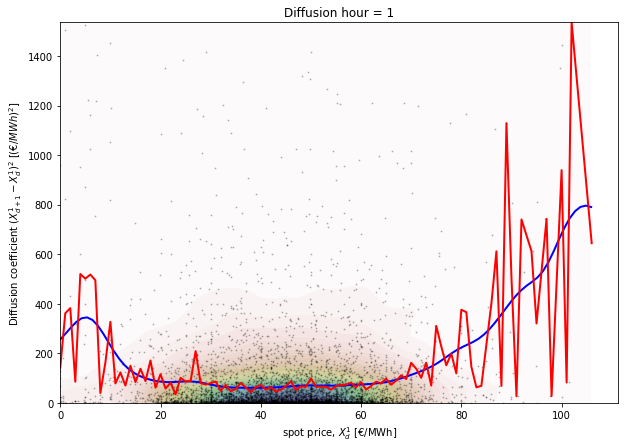

Hour: 1 -> Historical mean: 81.15 - Expected value from kernel: 72.16


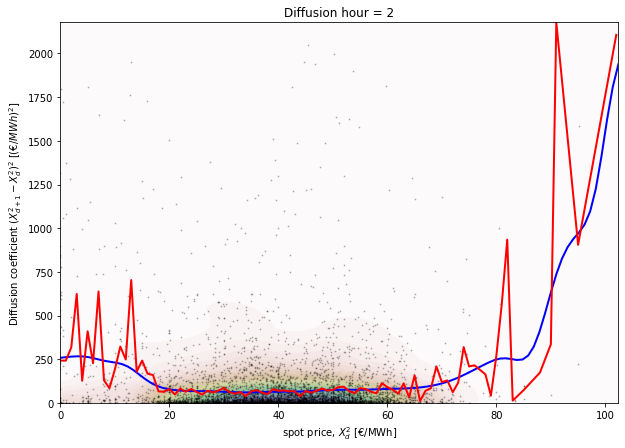

Hour: 2 -> Historical mean: 80.09 - Expected value from kernel: 70.47


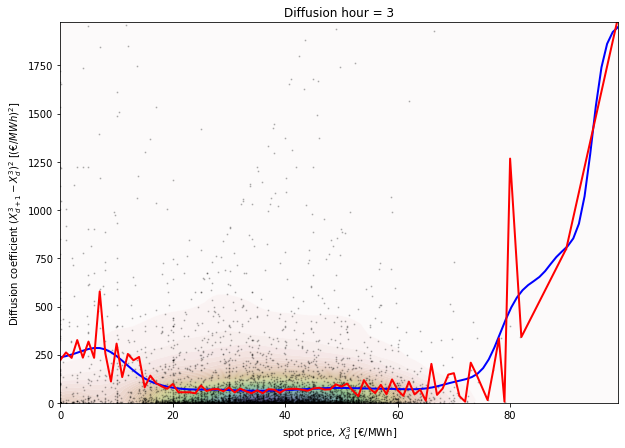

Hour: 3 -> Historical mean: 84.64 - Expected value from kernel: 73.26


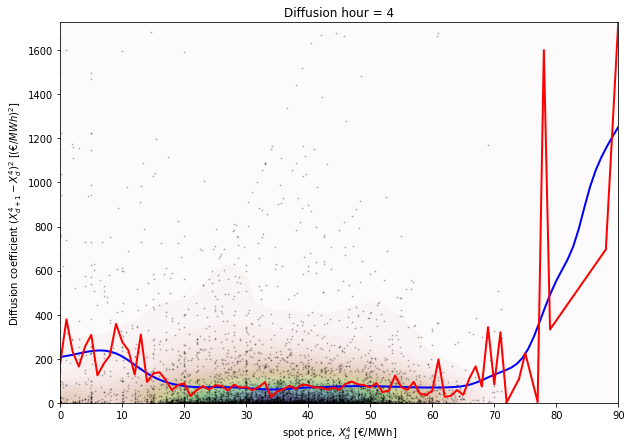

Hour: 4 -> Historical mean: 83.36 - Expected value from kernel: 73.61


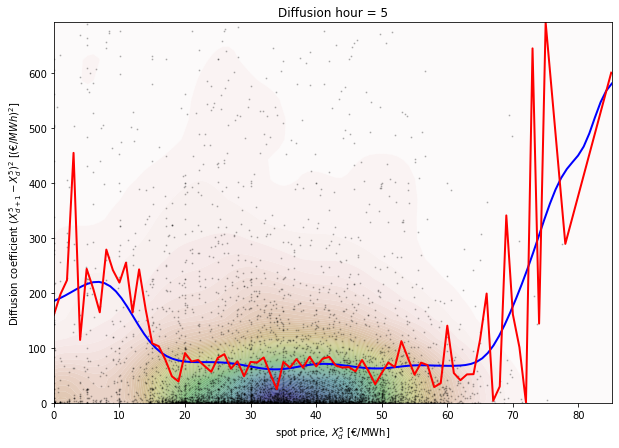

Hour: 5 -> Historical mean: 80.52 - Expected value from kernel: 70.89


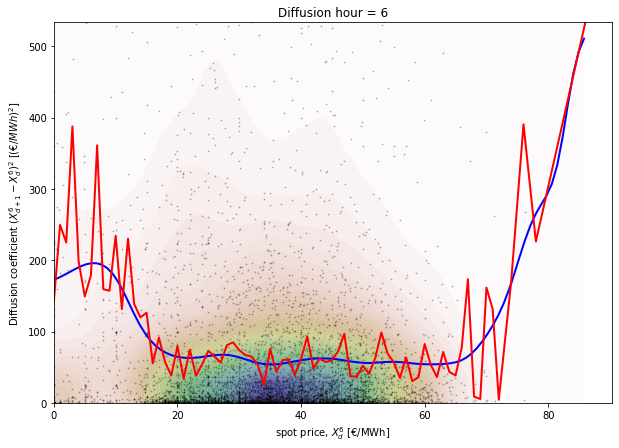

Hour: 6 -> Historical mean: 70.04 - Expected value from kernel: 62.33


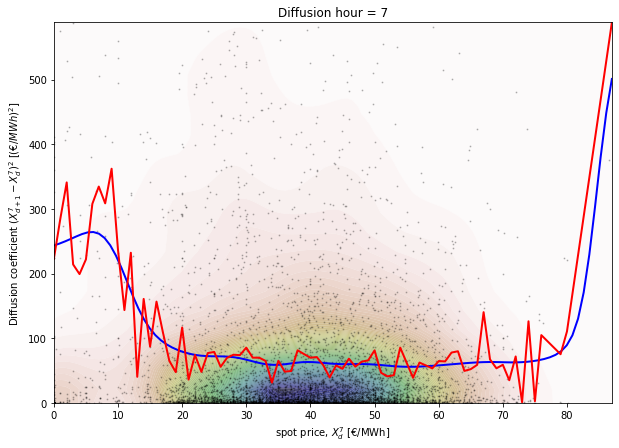

Hour: 7 -> Historical mean: 73.15 - Expected value from kernel: 64.20


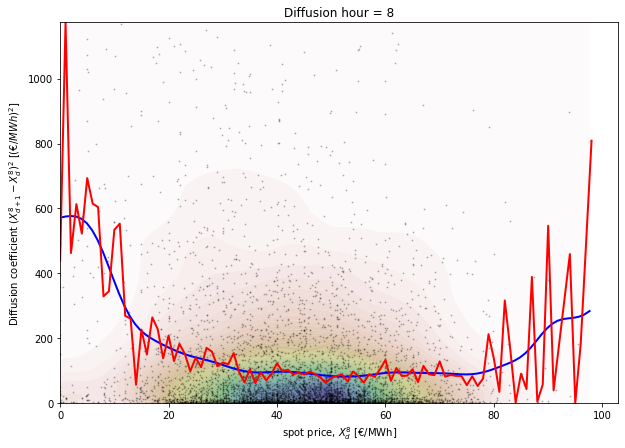

Hour: 8 -> Historical mean: 113.13 - Expected value from kernel: 98.02


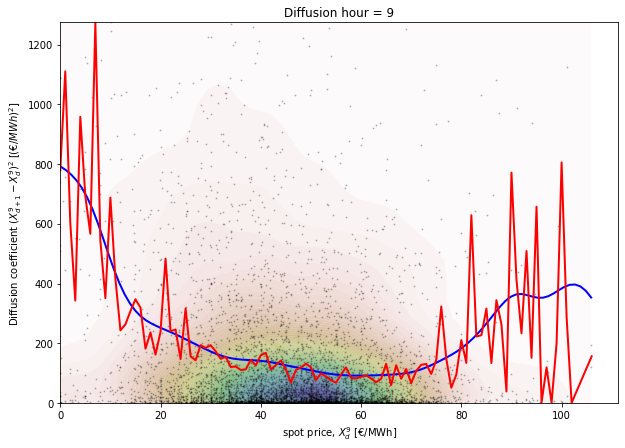

Hour: 9 -> Historical mean: 148.17 - Expected value from kernel: 124.35


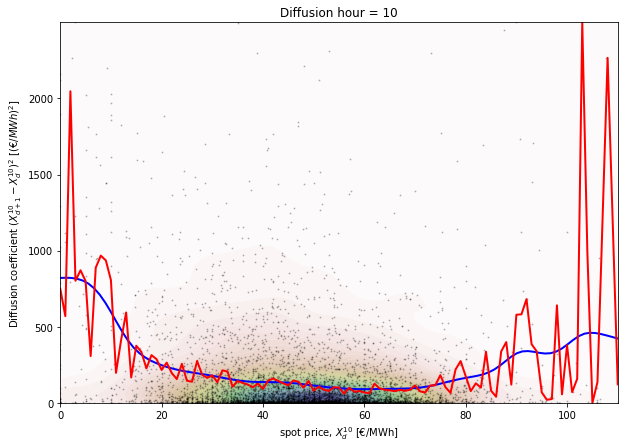

Hour: 10 -> Historical mean: 141.82 - Expected value from kernel: 122.14


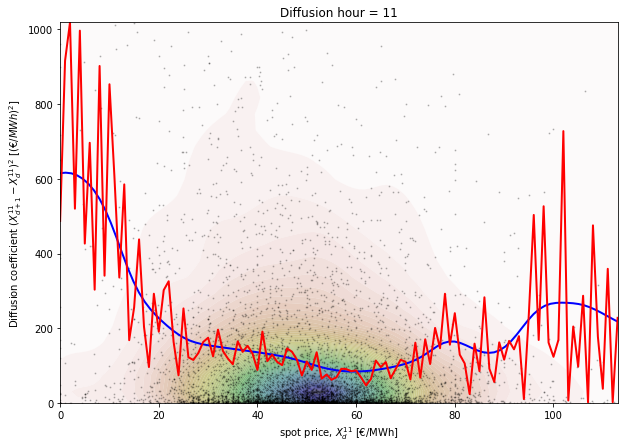

Hour: 11 -> Historical mean: 126.74 - Expected value from kernel: 114.33


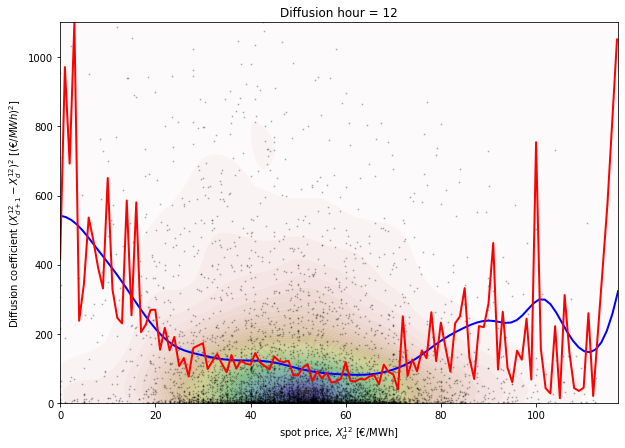

Hour: 12 -> Historical mean: 119.77 - Expected value from kernel: 108.05


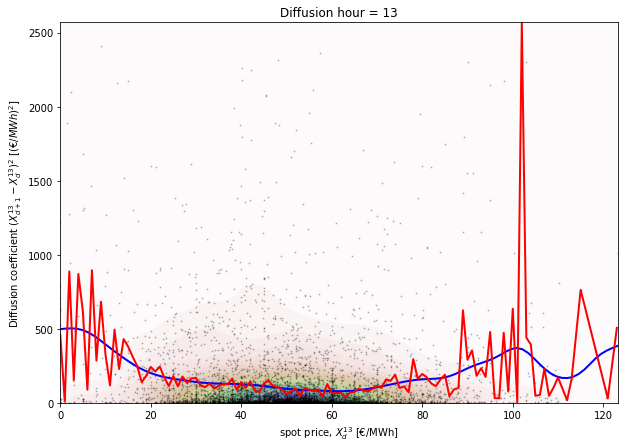

Hour: 13 -> Historical mean: 119.60 - Expected value from kernel: 107.67


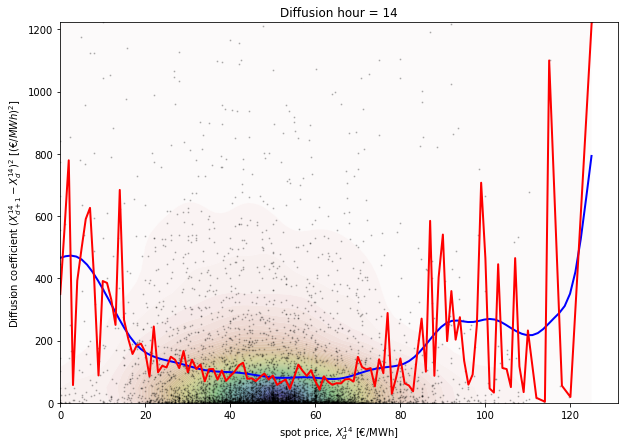

Hour: 14 -> Historical mean: 104.82 - Expected value from kernel: 94.25


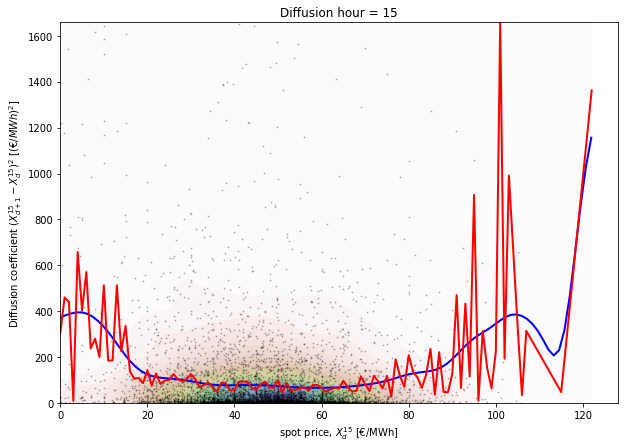

Hour: 15 -> Historical mean: 89.98 - Expected value from kernel: 79.41


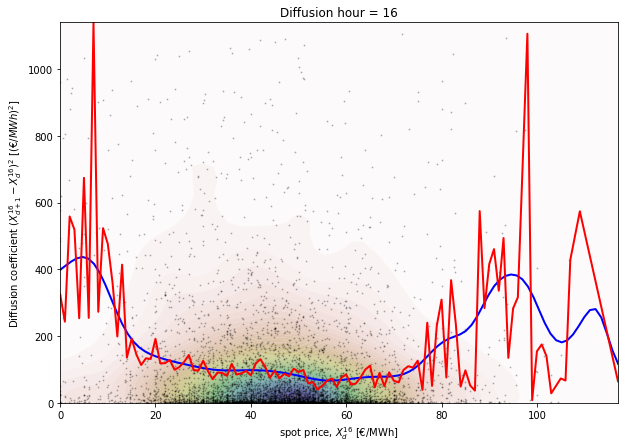

Hour: 16 -> Historical mean: 103.92 - Expected value from kernel: 90.21


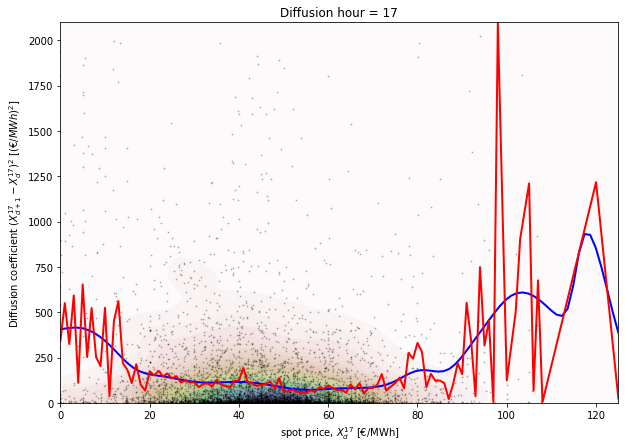

Hour: 17 -> Historical mean: 115.92 - Expected value from kernel: 99.92


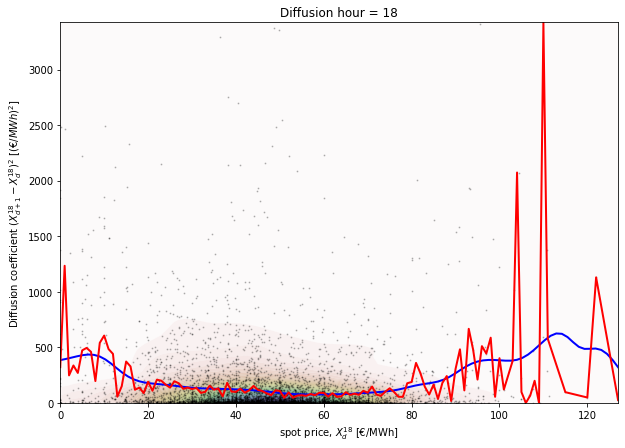

Hour: 18 -> Historical mean: 120.71 - Expected value from kernel: 103.77


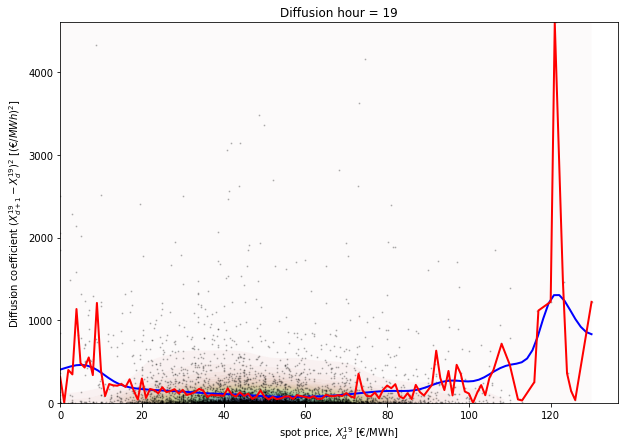

Hour: 19 -> Historical mean: 112.23 - Expected value from kernel: 98.48


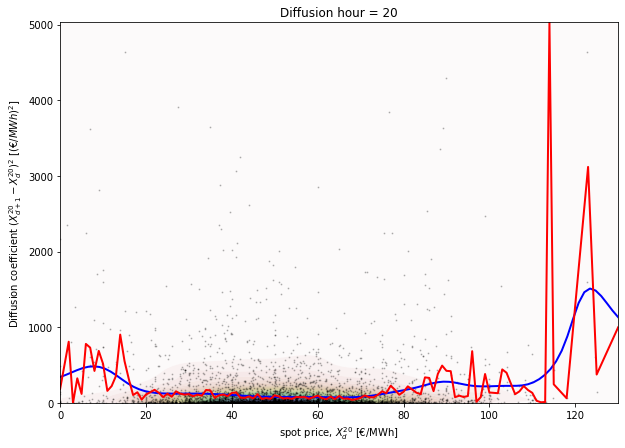

Hour: 20 -> Historical mean: 106.43 - Expected value from kernel: 93.75


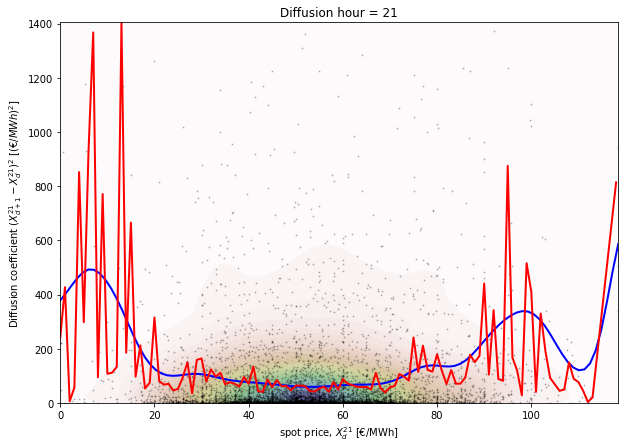

Hour: 21 -> Historical mean: 87.29 - Expected value from kernel: 74.92


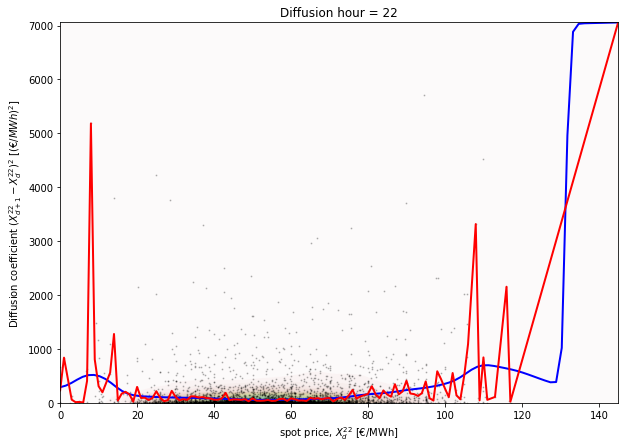

Hour: 22 -> Historical mean: 90.71 - Expected value from kernel: 76.70


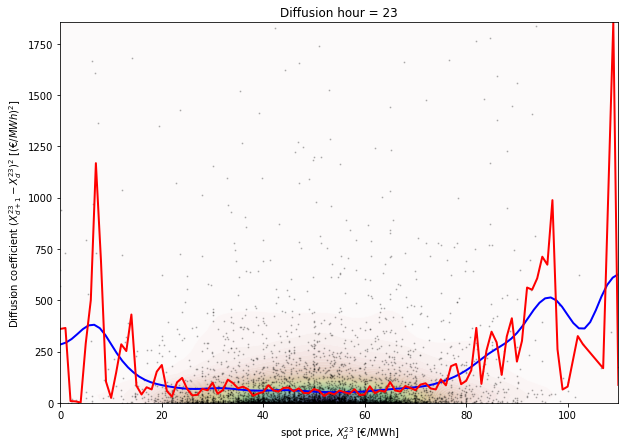

Hour: 23 -> Historical mean: 72.96 - Expected value from kernel: 62.85


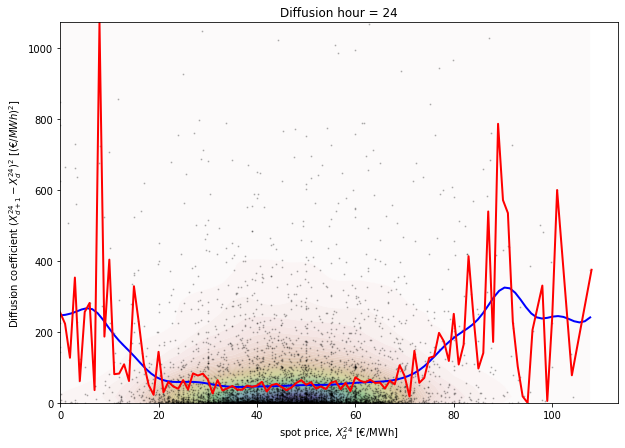

Hour: 24 -> Historical mean: 60.49 - Expected value from kernel: 53.16
CPU times: user 34.6 s, sys: 220 ms, total: 34.9 s
Wall time: 34.9 s


In [24]:
%%time
d_2_diag_hour_stats = {}
for i in range(1, 25):
    d_2_diag_hour_stats[i] = compute_diffusion_diagonal(vector_ts=s_kde, 
                                                        hour=i, 
                                                        x_mesh_num_points=100, 
                                                        y_mesh_num_points=100)

In [ ]:
d_2_diag_hour_stats[23]

In [ ]:
df_d_2_23 = s_kde.df.query("hour == 23")[["x_label", "diffusion_h_23"]].dropna()

In [ ]:
%%time
gk_d2_23 = GaussianKernel(samples=df_d_2_23, grid_shape=(100, 100), ymin=-100)

In [ ]:
pd.Series(gk_d2_23.expected_value_function[1, :], index=gk_d2_23.expected_value_function[0, :])

In [ ]:
d_2_diag_hour_stats[23]["expected_value_x"]

In [ ]:
gk_d2_23.expected_value_function

In [ ]:
gk_d2_23.most_likely

In [ ]:
foo = np.unravel_index(d_2_diag_hour_stats[23]["p"].argmax(),
           d_2_diag_hour_stats[23]["p"].shape) 

In [ ]:
foo

In [ ]:
d_2_diag_hour_stats[23]["price_probability"].argmax()

In [ ]:
d_2_diag_hour_stats[23]["y_grid"][47][3]

In [ ]:
d_2_diag_hour_stats[23]["expected_value_x"].iloc[47]#[3]

In [ ]:
gk_d2_23.expected_value_from_most_likely

In [ ]:
d_2_diag_hour_stats[23]["expected_diff"]

In [ ]:
gk_d2_23.expected_value

In [ ]:
gk_d2_23.most_likely

#### Non-diagonal $D_2^{h, j} \quad h \neq j$

In [25]:
def compute_expected_surface(x_grid: np.ndarray, y_grid: np.ndarray, z_grid: np.ndarray, p: np.ndarray):
    
    x_grid_prices = x_grid[:, :, 0]
    y_grid_prices = y_grid[:, :, 0]
    mesh_prices = np.vstack([x_grid_prices.ravel(), y_grid_prices.ravel()])
    
    mean_d = np.zeros_like(x_grid_prices.ravel())
    for i, x in enumerate(range(x_grid.shape[0])):
        for j, y in enumerate(range(y_grid[i].shape[0])):
            # if sum of probabilities across z is 0 do not compute average
            if np.sum(p[i][j]) == 0:
                # change
                mean_d[i*y_grid.shape[1]+j] = 0
            else:
                # change
                mean_d[i*y_grid.shape[1]+j] = np.average(z_grid[i][j], weights=p[i][j])
            
    return np.vstack([mesh_prices, mean_d])

def compute_expected_diff_coefficient_from_prob(kernel: stats.kde.gaussian_kde,
                                                expected_surface: np.ndarray):
    return np.average(expected_surface[2, :], weights=kernel(expected_surface))

def compute_expected_diff_from_most_likely_price(df: pd.DataFrame, 
                                                 x_grid: np.ndarray,
                                                 y_grid: np.ndarray,
                                                 expected_surface: np.ndarray):
    
    kernel_prices, values_prices = fit_gaussian_kde(df=df)
    
    x_grid_prices = x_grid[:, :, 0]
    y_grid_prices = y_grid[:, :, 0]
    mesh_prices = np.vstack([x_grid_prices.ravel(), y_grid_prices.ravel()])

    p_prices = compute_mesh_probability(kernel=kernel_prices, mesh=mesh_prices, new_shape=x_grid_prices.shape)
    
    #fig, ax = plt.subplots(figsize=(10, 7))
    #cs = ax.contourf(x_grid_prices, y_grid_prices, p_prices,
    #                levels=100, cmap=plt.cm.gist_earth_r, alpha=0.7, antialiased=True)
    #plt.show()
    
    max_i, max_j = np.unravel_index(p_prices.argmax(), p_prices.shape)
    #print(f"Most likely price (X_d^{{i}}, X_d^{{j}}):" + \
    #      f"({x_grid_prices[max_i][max_j]}, {y_grid_prices[max_i][max_j]})")
    #print(f"Expected diffusion coeffcient from most likely price (X^{{i}}, X^{{j}}, D_2):" + \
    #      f"{expected_surface[:, p_prices.argmax()]}")
    return expected_surface[:, p_prices.argmax()]
    

In [26]:
def compute_diffusion_non_diagonal(vector_ts: VectorTimeSeries, hour_i: int, hour_j: int, 
                                   x_mesh_num_points: int, y_mesh_num_points: int, z_mesh_num_points: int):
    
    x_label_col_name = vector_ts.x_col_name
    x_label_2_col_name = vector_ts.x_two_col_names[hour_j-1]
    diff_col_name = vector_ts.diffusion_cols[hour_j-1]
    cols = [x_label_col_name, x_label_2_col_name, diff_col_name]
    
    diff_df = vector_ts.df.query(f"hour == {hour_i}")[cols]
    
    train_df = diff_df.copy(deep=True).dropna()
    
    kernel, values = fit_gaussian_kde(df=train_df)
    
    mesh, x_grid, y_grid, z_grid = generate_mesh(values=values, 
                                                 x_num=x_mesh_num_points, 
                                                 y_num=y_mesh_num_points, 
                                                 z_num=z_mesh_num_points)
    
    p = compute_mesh_probability(kernel=kernel, mesh=mesh, new_shape=x_grid.shape)
    
    expected_surface = compute_expected_surface(x_grid=x_grid, y_grid=y_grid, z_grid=z_grid, p=p)
    
    #fig = plt.figure(figsize=(20, 12))
    #ax = fig.add_subplot(111, projection='3d')
    #ax.plot_trisurf(expected_surface[0], expected_surface[1], expected_surface[2], alpha=0.7)
    #plt.show()
    
    # average of expected D_2 based on probability of each D_2 point (X_i, X_j, expected D_2)
    expected_diff = compute_expected_diff_coefficient_from_prob(kernel=kernel,
                                                                expected_surface=expected_surface)
    
    #print(f"Expected D_2: {expected_coefficient:.4f}")
    
    # expected D_2 of most likely price (X_i, X_j)
    prices_df = diff_df[[x_label_col_name, x_label_2_col_name]].dropna()
    expected_diff_most_likely_price = compute_expected_diff_from_most_likely_price(
        df=prices_df, x_grid=x_grid, y_grid=y_grid, expected_surface=expected_surface
    )
    
    x_index, y_index, z_index = np.unravel_index(p.argmax(), p.shape)
    most_likely_diff = np.array([
        x_grid[x_index][y_index][z_index], y_grid[x_index][y_index][z_index], z_grid[x_index][y_index][z_index]
    ])
    #print(f"Most likely D_2 (X^{{i}}, X^{{j}}, D_2): {x_grid[x_index][y_index][z_index]:.2f}, {y_grid[x_index][y_index][z_index]:.2f}, " + \
    #      f"{z_grid[x_index][y_index][z_index]:.4f}")
    return{
        "hour_i": hour_i,
        "hour_j": hour_j,
        "expected_diff": expected_diff,
        "expected_diff_most_likely_price": expected_diff_most_likely_price,
        "most_likely_diff": most_likely_diff,
        "kernel": kernel #TODO: remove it!
    }
    

In [27]:
%%time
foo = compute_diffusion_non_diagonal(
    vector_ts=s_kde, hour_i=24, hour_j=23, x_mesh_num_points=100, y_mesh_num_points=100, z_mesh_num_points=100
)

CPU times: user 2min 14s, sys: 633 ms, total: 2min 14s
Wall time: 2min 19s


In [28]:
foo

{'hour_i': 24,
 'hour_j': 23,
 'expected_diff': 44.05587292448311,
 'expected_diff_most_likely_price': array([50.05171717, 52.22222222, 29.9270826 ]),
 'most_likely_diff': array([50.05171717, 52.22222222, 21.80090909]),
 'kernel': <scipy.stats.kde.gaussian_kde at 0x7f9cf114e490>}

In [29]:
%%time
df_d_2_23_24 = s_kde.df.query("hour == 24")[["x_label", "x_label_2_h_23", "diffusion_h_23"]].dropna()
gk_d2_23_24 = GaussianKernel(samples=df_d_2_23_24, grid_shape=(100, 100, 100))

CPU times: user 2min 15s, sys: 777 ms, total: 2min 16s
Wall time: 2min 21s


In [30]:
%%time
gk_d2_23_24_nb = GaussianKernel(samples=df_d_2_23_24, grid_shape=(100, 100, 100), 
                             parallel_mode=ComputationMode.Numba)

CPU times: user 2min 11s, sys: 904 ms, total: 2min 12s
Wall time: 2min 17s


In [31]:
%%time
_ = gk_d2_23_24._compute_expected_value_function(grid=gk_d2_23_24.grid, p=gk_d2_23_24.p)

CPU times: user 241 ms, sys: 13 µs, total: 241 ms
Wall time: 240 ms


In [32]:
%%time
_ = gk_d2_23_24_nb._compute_expected_value_function(grid=gk_d2_23_24_nb.grid, p=gk_d2_23_24_nb.p)

CPU times: user 5.88 ms, sys: 0 ns, total: 5.88 ms
Wall time: 5.7 ms


In [33]:
np.testing.assert_allclose(gk_d2_23_24.expected_value_function, gk_d2_23_24_nb.expected_value_function, rtol=1e-10)

In [ ]:
gk_d2_23_24.expected_value

In [ ]:
gk_d2_23_24.most_likely

In [ ]:
gk_d2_23_24.expected_value_from_most_likely

In [ ]:
np.unravel_index(gk_d2_23_24.p.argmax(), gk_d2_23_24.p.shape)

In [ ]:
gk_d2_23_24.p.shape

In [ ]:
gk_d2_23_24.grid[0].shape[0]

In [ ]:
20*30

In [ ]:
gk_d2_23_24.expected_value_function[:, 18*30+10]

In [ ]:
gk_d2_23_24.grid[0][18, 0, 0]

In [ ]:
gk_d2_23_24.grid[1][0, 10, 0]

In [ ]:
gk_d2_23_24.grid[2][18, 10]

In [ ]:
gk_d2_23_24.p[18, 10]

In [ ]:
np.average(gk_d2_23_24.grid[2][18, 10], weights=gk_d2_23_24.p[18, 10])

In [ ]:
gk_d2_23_24.p.argmax()

In [ ]:
gk_d2_23_24.grid[0][9, 14, 3]

In [ ]:
gk_d2_23_24.grid[1][9, 14, 3]

In [ ]:
np.argwhere(gk_d2_23_24.grid[0][:, :, 0].ravel() == 51.02526315789474)

In [ ]:
np.argwhere(gk_d2_23_24.grid[1][:, :, 0].ravel() == 53.10344827586207)

In [ ]:
gk_d2_23_24.expected_value_function[:, 284]

In [ ]:
np.where(gk_d2_23_24.expected_value_function[0, :] == 50.05171717)

In [ ]:
foo["kernel"].resample(size=1000000, seed=174)[2, :].mean()

In [ ]:
foo

In [ ]:
foo

In [ ]:
foo

In [ ]:
foo

In [ ]:
s.diffusion_matrix

In [ ]:
hour_i_list = []
hour_j_list = []
for i in np.arange(24, 1, -1):
    for j in range(i-1, 0, -1):
        hour_i_list.append(i)
        hour_j_list.append(j)

In [ ]:
from joblib import Parallel, delayed

In [ ]:
import pickle

In [ ]:
with open('d2_coefficients.pkl', 'rb') as f:
    d2_coefficients_batch_1 = pickle.load(f)

In [ ]:
%%time
d_2_list = Parallel(n_jobs=-1, verbose=1)(delayed(compute_diffusion_non_diagonal)(
    vector_ts=s_kde, hour_i=i, hour_j=j, x_mesh_num_points=100, y_mesh_num_points=100, z_mesh_num_points=100
) for i, j in zip(hour_i_list[210:], hour_j_list[210:]))

In [ ]:
d2_pickle_list = []
for i in range(1, 5):
    with open(f"d2_coefficients_batch_{i}.pkl", "rb") as f:
        d2_pickle_list.append(pickle.load(f))

In [ ]:
d2_coefficient_list = []
for element in d2_pickle_list:
    for k in element:
        d2_coefficient_list.append(k)

In [ ]:
len(d2_coefficient_list)

In [ ]:
d2_coefficient_list[]

In [ ]:
for k in d2_coefficient_list:
    print(k["hour_i"], k["hour_j"], k["most_likely_diff"][-1])

In [ ]:
len(d2_coefficient_list)

In [ ]:
with open("d2_coefficients_batch_4.pkl", "wb") as f:
    pickle.dump(d_2_list, f)

In [ ]:
# diffusion matrix
diff_matrix = np.zeros((24, 24))

In [ ]:
for element in d2_coefficient_list:
    diff_matrix[element["hour_i"] - 1, element["hour_j"] - 1] = element["expected_diff_most_likely_price"][-1]

In [ ]:
df.iloc[:24]["spain"].values

In [ ]:
for k,v in d_2_diag_hour_stats.items():
    #closet_index = np.abs(v["expected_value_x"].index - df.iloc[-24:]["spain"].values[k-1]).argmin()
    #diff_matrix[k-1, k-1] = v["expected_value_x"].iloc[closet_index]
    
    #diff_matrix[k-1, k-1] = v["expected_diff"]
    
    diff_matrix[k-1, k-1] = v["expected_value_x"].iloc[v["price_probability"].argmax()]

In [ ]:
diff_matrix = diff_matrix + np.tril(diff_matrix, k=-1).T

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
#mask = np.triu(np.ones_like(diff_matrix, dtype=bool), k=1)
sns.heatmap(diff_matrix, cmap="flare",
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
#mask = np.triu(np.ones_like(diff_matrix, dtype=bool), k=1)
sns.heatmap(s.diffusion_matrix, cmap="flare",
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

In [ ]:
from scipy.linalg import sqrtm

In [ ]:
pd.Series(np.linalg.eigvals(diff_matrix)).sort_values()

In [ ]:
sqrtm(diff_matrix)

In [ ]:
pd.DataFrame(diff_matrix)

In [ ]:
np.random.seed(72)
result = np.dot(sqrtm(diff_matrix), np.random.normal(loc=0, scale=1, size=(24, 1))) + \
df.iloc[-24:]["spain"].values.reshape(-1, 1)

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(24), result.real.reshape(-1))
ax.plot(range(24), df.iloc[-24:]["spain"].values)

In [ ]:
df.iloc[-24:]["spain"].values.reshape(-1, 1).shape

In [ ]:
np.random.seed(22)
result = np.abs(np.dot(sqrtm(diff_matrix), np.random.normal(loc=0, scale=1, size=(24, 1))))+ \
df.iloc[-24:]["spain"].values.reshape(-1, 1)

fig, ax = plt.subplots()
ax.plot(range(24), result)
ax.plot(range(24), df.iloc[-24:]["spain"].values)

Compute price inflation as mean daily prices - mean drfit and learn this through a neural ODE